In [ ]:
%%capture install
try:
  import imlms
  print('Already installed')
except:
  %pip install git+https://github.com/Mads-PeterVC/imlms

In [ ]:
print(install.stdout.splitlines()[-1])

In [ ]:
import numpy as np

# Interatomic Potentials

Interatomic potentials are a key concept in materials science.

We have seen previously that we can predict e.g. lattice constants and adsorption sites
using a potential.

For now we will work with a simple Lennard Jones potential.

## The Lennard Jones Potential

The Lennard Jones potential is among the simplest analytical potentials, it is a
two-body potential where the interaction between a pair of atoms is given by
$$
V(r) = 4 \epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right]
$$

Where $r$ is the distance between the atoms $\sigma$ is a parameter that determines the
location of the minimum and $\epsilon$ determines the depth of the minimum.

### Exercise: Energy of a pair of atoms.

Implement a function that takes the distance `r`, `sigma` and `epsilon` and returns the Lennard Jones
potential.

In [ ]:
def get_lj_energy(r, sigma, epsilon):
    E = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
    return E

It is often best to work with functions that take arrays as that allows for avoiding
slow for-loops. So test whether your function works with an `numpy` array - otherwise
change it so that it does;

In [ ]:
get_lj_energy(np.array([1, 2, 3]), 2**(-1/6), 1) # Your function works if the first value of output array is -1.0

array([-1.        , -0.03100586, -0.0027416 ])

Plot the energy as a function of $r$ and play around with the parameters to get a feel for what they do.

### Exercise: Energy of an `Atoms` object.

Implement a function `calculate` that takes an `Atoms`-object, `sigma` and `epsilon` and returns the
total energy according to the Lennard Jones expression.

Hint: First create an array that contains the distance between all pairs of atoms,
you can use the [`pdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)
function from scipy to do this. Then pass that to your `get_lj_energy` function and sum
all the terms together.

Hint: You can get the positions of the atoms object with `atoms.positions`

Hint: Use `np.sum` to sum over the returned values of `get_lj_energy`

In [ ]:
from scipy.spatial.distance import pdist

def calculate(atoms, sigma, epsilon):
    d = pdist(atoms)
    E = np.sum(get_lj_energy(d, sigma, epsilon))
    return E

In [ ]:
for r in [0.8, 1.0, 1.2]:

    atoms = Atoms('H2', positions=[[0, 0, 0], [r, 0, 0]])
    E = calculate(atoms.positions, 2**(-1/6), 1)
    print(f'Energy for r = {r:0.2f} is {E:0.2f}')

Energy for r = 0.80 is 6.92
Energy for r = 1.00 is -1.00
Energy for r = 1.20 is -0.56


### Exercise: Lennard Jones with Object Oriented Programming

The code we have written so far is functional; we have created functions that take some input and return output - without
any type of state/memory. Yet, the inputs we have passed are not really of the same type - the `Atoms` object is
really the variable and `sigma` and `epsilon` are parameters of the function.

If is often beneficial to create classes in these types of situations and is very
commonly done.

### Exercise: Computing forces

It is often useful to calculate not only the energy but also the force on each atom. The components
of the forces are given by
$$
F_i^\alpha = -\frac{\partial E}{\partial x_i^\alpha}
$$

Where $i$ indicates the atom and $\alpha$ denotes either the $x$, $y$ or $z$ dimension.

This can be applied to the Lennard Jones expression, but it is cumbersome and
more difficult to implement than the potential itself - but if you want to try
you can. Note that the potential is not given directly in terms of the coordinates,
but rather in terms of the distance between atoms, so that needs to be taken into account.

This exercise is very **optional** and probably best left as an extra for the interested.

### Exercise: Lennard Jones with Pytorch

As stepping stone to implementing neural network based potentials we will first
look at implementing the Lennard Jones potential using Pytorch.

To do so, we should replace all `numpy` or `scipy` functions in our implementation
with `torch` functions and any use of arrays from `numpy` should be replaced
with `torch.tensor`.

One of the main benefits of doing this is that we can calculate forces using
*automatic differentiation* the same technique that enables training of neural networks.

In the cell below you should fill out the left out code.

In [ ]:

import torch

class LennardJonesTorch:

    def __init__(self, sigma=1.0, epsilon=1.0):
        self.sigma = sigma
        self.epsilon = epsilon

    def atoms_to_tensor(self, atoms):
        return torch.tensor(atoms.positions, requires_grad=True)

    def get_lj_energy(self, r):
        # Calculate the Lennard-Jones energy using the class attributes
        # self.sigma and self.epsilon.
        return 4 * self.epsilon * ((self.sigma/r)**12 - (self.sigma/r)**6)

    def get_forces(self, energy, positions):
        return -torch.autograd.grad(energy, positions, retain_graph=True)[0]

    def calculate(self, atoms):
        # Convert the positions to a tensor
        positions = self.atoms_to_tensor(atoms)
        return self.forward(positions)

    def forward(self, positions):
        # Calculate the pairwise distances
        d = torch.pdist(positions)

        # Calculate the Lennard-Jones energy
        E = torch.sum(self.get_lj_energy(d))
        F = self.get_forces(E, positions)

        # Return the energy and forces
        E = E.detach().numpy() # Convert back to numpy
        F = F.detach().numpy()
        return E, F

In [ ]:
from ase import Atoms

LJT = LennardJonesTorch(sigma=2**(-1/6))

for r in [0.8, 1.0, 1.2]:
    atoms = Atoms('H2', positions=[[0.0, 0.0, 0.0], [r, 0.0, 0.0]])

    energy, forces = LJT.calculate(atoms)

    print(f'r = {r:0.2f}')
    print(f'\tEnergy = {energy:0.2f}')
    print(f'\t Left atom force = {forces[0][0]:0.2f}')
    print(f'\t Right atom force = {forces[1][0]:0.2f}')

r = 0.80
	Energy = 6.92
	 Left atom force = -161.06
	 Right atom force = 161.06
r = 1.00
	Energy = -1.00
	 Left atom force = 0.00
	 Right atom force = -0.00
r = 1.20
	Energy = -0.56
	 Left atom force = 2.23
	 Right atom force = -2.23


You should find the following;

- At `r = 0.80` there is a large repulsive force between the atoms as the bond length is significantly smaller than the equilibrium.
- At `r = 1.00` the is no force as the atoms are at the equilibrium bond length.
- At `r = 12.0` there is an attractive force between the atoms as the bond is now stretched beyond the equilibrium.

### Exercise: Using atomic forces

One common use case of atomic forces is local optimization or 'relaxation'.
Here the energy is minimized by moving the atoms according to the forces,
this is analagous to a ball rolling down a hill to find a
position that minimizes the gravitational potential energy.

ASE makes this very easy, the code below converts your `LennardJonesTorch`
to an `ase` `Calculator` such that it can interface with the rest of the functionality.

In [ ]:
from imlms import get_calculator_from_class

LJT = get_calculator_from_class(LennardJonesTorch)(sigma=1.0, epsilon=1.0)

atoms = Atoms('H2', positions=[[0.0, 0.0, 0.0], [1.5, 0.0, 0.0]])
atoms.calc = LJT
E = atoms.get_potential_energy()
print(E)

-0.3203365942785745


Read this section on [optimizers](https://wiki.fysik.dtu.dk/ase/gettingstarted/tut02_h2o_structure/h2o.html#optimizers)
from the `ase` documentation and relax a small molecule, e.g. H2 with your Lennard Jones potential.

In [ ]:
from ase.optimize import BFGS

atoms = Atoms('H2', positions=[[0.0, 0.0, 0.0], [1.5, 0.0, 0.0]])
atoms.calc = LJT

optimizer = BFGS(atoms)
optimizer.run(fmax=1e-3)

print(atoms.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 12:18:18       -0.320337        1.158029
BFGS:    1 12:18:18       -0.361161        1.312428
BFGS:    2 12:18:18       -0.921519        2.041011
BFGS:    3 12:18:18       55.298954      974.487533
BFGS:    4 12:18:18       -0.923220        2.028761
BFGS:    5 12:18:18       -0.924897        2.016337
BFGS:    6 12:18:18       -0.752559        8.517609
BFGS:    7 12:18:18       -0.970548        1.472894
BFGS:    8 12:18:18       -0.990140        0.939655
BFGS:    9 12:18:18       -0.997803        0.528593
BFGS:   10 12:18:18       -0.999924        0.092418
BFGS:   11 12:18:18       -1.000000        0.007274
BFGS:   12 12:18:18       -1.000000        0.000113
-0.9999999998888873


The cell below creates a random cluster of ten Helium atoms and relaxes it using our
Lennard Jones model written in Pytorch.

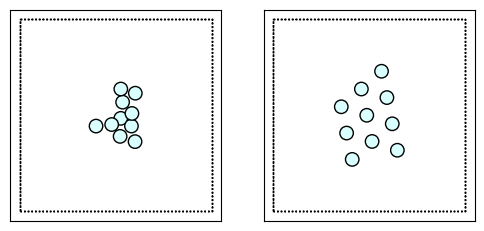

In [ ]:
import matplotlib.pyplot as plt
from imlms.potentials.get_random_cluster import get_random_cluster, plot_atoms, plot_cell
from ase.constraints import FixedPlane

atoms = get_random_cluster()

optimized = atoms.copy()
optimized.calc = LJT
optimized.set_constraint(FixedPlane(np.arange(len(atoms)), [0, 0, 1])) # Fix the z-coordinate
optimizer = BFGS(optimized, logfile=None)
optimizer.run(fmax=1e-3)
optimized.center() # Center the atoms

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

for ax, atoms in zip(axes, [atoms, optimized]):
    plot_atoms(ax, atoms)
    plot_cell(ax, atoms.cell)
